In [1]:
pip install torch-pruning 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Method
I will be using maginutde based pruning, the group of channel with lowes L2 norm will be pruned iteratively.
Layer-adaptive sparsity for the Magnitude-based Pruning: https://arxiv.org/abs/2010.07611



In [20]:
import torch 
import torch.nn as nn
import torchvision
from torchvision import transforms
from tqdm import tqdm
from torch.optim import lr_scheduler
import torch.optim as optim
import time
import os
import random
import shutil
# import torch_pruning as tp

In [3]:
!pip install torchsummary

paper: https://arxiv.org/pdf/2305.14403.pdf

# Model Loading, Dataset Prep

In [4]:
model = torch.load('/kaggle/input/pruning-effficientnet-v2-s-on-cifar10/81%_pruned_unmasked_model.pt')

In [21]:
#All the necessary code to load and configure the dataset 

batch_size = 32
path = '/kaggle/input/cifar10-python'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


trainset = torchvision.datasets.CIFAR10(root=path, 
                                        train=True, download=False, 
                                        transform=data_transforms['train'])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)


testset = torchvision.datasets.CIFAR10(root=path, 
                                        train=False, download=False, 
                                        transform=data_transforms['test'])

                                     
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



#Making things easy, so storing it in a dictionary 
dataset_size = [len(trainset), len(testset)]
dataloaders= {
    "train": trainloader,
    "val": testloader
}
dataset_sizes = {
    "train": dataset_size[0],
    "val": dataset_size[1]
}



#Evaluating the model performance on the test set
def evaluate_model(model, criterion = nn.CrossEntropyLoss() , dataloader = testloader ):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    eval_loss = running_loss / len(dataloader.dataset)
    eval_acc = running_corrects.double() / len(dataloader.dataset)

    print(f'Evaluation Loss: {eval_loss:.4f} Acc: {eval_acc:.4f}')

    return eval_loss, eval_acc




class_names = trainset.classes

# Train defination 

In [22]:
#train & evaluate

#Function for training the model, forware prop and backward prop 
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    #storing epoch data
    epoch_data =     {
        'epoch': [],
        'train': {'loss': [], 'acc': []},
        'val': {'loss': [], 'acc': [] }
    }
    
    # Create a temporary directory in Kaggle's temp directory
    tempdir = '/kaggle/working/temp'
    os.makedirs(tempdir, exist_ok=True)
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        epoch_data['epoch'].append(epoch+1)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            

            for inputs, labels in tqdm(dataloaders[phase], leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_data[phase]['loss'].append(epoch_loss)
            epoch_data[phase]['acc'].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(torch.load(best_model_params_path))

    # Clean up the temporary directory
    shutil.rmtree(tempdir)

    return model, epoch_data


In [7]:
#train and dataloader code at the end
#example inputs 
for img, label in trainloader:
    example_inputs = img
    break
print(img.shape)
example_inputs= example_inputs.to(device)

torch.Size([32, 3, 224, 224])


In [8]:
print(model.features[0])
print(model.features[1])

Conv2dNormActivation(
  (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
)
Sequential(
  (0): FusedMBConv(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
    )
    (stochastic_depth): StochasticDepth(p=0.0, mode=row)
  )
  (1): FusedMBConv(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
    )
    (stochastic_depth): StochasticDepth(p=0.005, mode=row)
  )
)


In [16]:
def get_channel_sizes(model):
    channel_sizes = []

    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            channel_sizes.append(module.out_channels)
        
    print(channel_sizes)
    print('\n..................\nTotal:', len(channel_sizes))
    return channel_sizes

In [9]:
#Intial channels
get_channel_sizes(model)


[24, 24, 24, 96, 48, 192, 48, 192, 48, 192, 48, 192, 64, 256, 64, 256, 64, 256, 64, 256, 256, 16, 256, 128, 512, 512, 32, 512, 128, 512, 512, 32, 512, 128, 512, 512, 32, 512, 128, 512, 512, 32, 512, 128, 512, 512, 32, 512, 128, 768, 768, 32, 768, 160, 960, 960, 40, 960, 160, 960, 960, 40, 960, 160, 960, 960, 40, 960, 160, 960, 960, 40, 960, 160, 960, 960, 40, 960, 160, 960, 960, 40, 960, 160, 960, 960, 40, 960, 160, 960, 960, 40, 960, 160, 960, 960, 40, 960, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1280]

..................
Total: 170


# Defining Pruning

In [10]:
# 1. ignore some layers that should not be pruned: the final classifier layer & 
#first 2 MbConv blocks of efficientnet V2 will not be pruned, this is important.
ignored_layers = []
for m in model.modules():
    if isinstance(m, torch.nn.Linear):
        ignored_layers.append(m) # DO NOT prune the final classifier!
        
for m in model.features[0].modules():  #Ignoring Conv2dNorm
    if isinstance(m, torchvision.ops.misc.Conv2dNormActivation):
        ignored_layers.append(m)
    
for m in model.features[0].modules():  #Ignoring 2MB conv blocks
    if isinstance(m, torchvision.ops.misc.Conv2dNormActivation):
        ignored_layers.append(m)
        
print(ignored_layers)

[Linear(in_features=1280, out_features=10, bias=True), Conv2dNormActivation(
  (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
), Conv2dNormActivation(
  (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
)]


In [11]:
imp = tp.importance.LAMPImportance()

In [12]:
# 2. Pruner initialization
iterative_steps = 10 # You can prune your model to the target sparsity iteratively. #importance parameter
pruner = tp.pruner.MagnitudePruner(
    model, 
    example_inputs, 
    global_pruning=True, # If False, a uniform sparsity will be assigned to different layers.
    importance=imp, # importance criterion for parameter selection
    iterative_steps=iterative_steps, # the number of iterations to achieve target sparsity
    ch_sparsity=0.8, # Remove 80% channels, 
    ignored_layers=ignored_layers,
)


# Iterative Pruning

In [13]:
print('Started channel pruning   ')
base_macs, base_nparams = tp.utils.count_ops_and_params(model, example_inputs)
for i in range(iterative_steps):
    pruner.step()
    print(f'Iteration   {i+1} / {iterative_steps+1}---------------------------')
    macs, nparams = tp.utils.count_ops_and_params(model, example_inputs)
    print(model(example_inputs).shape)
    print(
        "  Iter %d/%d, Params: %.2f M => %.2f M"
        % (i+1, iterative_steps, base_nparams / 1e6, nparams / 1e6)
    )
    print(
        "  Iter %d/%d, MACs: %.2f G => %.2f G"
        % (i+1, iterative_steps, base_macs / 1e9, macs / 1e9)
    )
    print("="*16)
    evaluate_model(model)
    ret_epoch = 3+i
    print(f'\n----------- Retraining for {ret_epoch} epochs-------------')
    
    
    #retraining the model 
    criterion = nn.CrossEntropyLoss()
    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    
    model, _ = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs= 3 + i )
    name= (80/10)*(i+1)
    torch.save(model, f'pruned_model_{name}%.pth')

Started channel pruning   
Iteration   1 / 11---------------------------
torch.Size([32, 10])
  Iter 1/10, Params: 20.19 M => 18.07 M
  Iter 1/10, MACs: 2.88 G => 2.80 G


100%|██████████| 313/313 [00:33<00:00,  9.25it/s]


Evaluation Loss: 0.5805 Acc: 0.8219

----------- Retraining for 3 epochs-------------
Epoch 1/3
----------


train Loss: 0.0847 Acc: 0.9702


val Loss: 0.1191 Acc: 0.9658

Epoch 2/3
----------


train Loss: 0.0500 Acc: 0.9831


val Loss: 0.1127 Acc: 0.9710

Epoch 3/3
----------


train Loss: 0.0367 Acc: 0.9879


val Loss: 0.1019 Acc: 0.9732

Training complete in 22m 12s
Best val Acc: 0.973200
Iteration   2 / 11---------------------------
torch.Size([32, 10])
  Iter 2/10, Params: 20.19 M => 16.01 M
  Iter 2/10, MACs: 2.88 G => 2.71 G


100%|██████████| 313/313 [00:31<00:00, 10.00it/s]


Evaluation Loss: 0.7201 Acc: 0.7491

----------- Retraining for 4 epochs-------------
Epoch 1/4
----------


train Loss: 0.0457 Acc: 0.9845


val Loss: 0.1058 Acc: 0.9703

Epoch 2/4
----------


train Loss: 0.0320 Acc: 0.9893


val Loss: 0.1053 Acc: 0.9725

Epoch 3/4
----------


train Loss: 0.0245 Acc: 0.9917


val Loss: 0.1067 Acc: 0.9740

Epoch 4/4
----------


train Loss: 0.0212 Acc: 0.9930


val Loss: 0.1074 Acc: 0.9731

Training complete in 28m 49s
Best val Acc: 0.974000
Iteration   3 / 11---------------------------
torch.Size([32, 10])
  Iter 3/10, Params: 20.19 M => 14.06 M
  Iter 3/10, MACs: 2.88 G => 2.61 G


100%|██████████| 313/313 [00:30<00:00, 10.29it/s]


Evaluation Loss: 0.7596 Acc: 0.7302

----------- Retraining for 5 epochs-------------
Epoch 1/5
----------


train Loss: 0.0386 Acc: 0.9871


val Loss: 0.1119 Acc: 0.9698

Epoch 2/5
----------


train Loss: 0.0267 Acc: 0.9912


val Loss: 0.1108 Acc: 0.9722

Epoch 3/5
----------


train Loss: 0.0206 Acc: 0.9932


val Loss: 0.1165 Acc: 0.9712

Epoch 4/5
----------


train Loss: 0.0159 Acc: 0.9949


val Loss: 0.1155 Acc: 0.9718

Epoch 5/5
----------


train Loss: 0.0140 Acc: 0.9953


val Loss: 0.1135 Acc: 0.9736

Training complete in 34m 33s
Best val Acc: 0.973600
Iteration   4 / 11---------------------------
torch.Size([32, 10])
  Iter 4/10, Params: 20.19 M => 12.24 M
  Iter 4/10, MACs: 2.88 G => 2.50 G


100%|██████████| 313/313 [00:29<00:00, 10.58it/s]


Evaluation Loss: 0.5882 Acc: 0.8330

----------- Retraining for 6 epochs-------------
Epoch 1/6
----------


train Loss: 0.0366 Acc: 0.9879


val Loss: 0.1136 Acc: 0.9695

Epoch 2/6
----------


train Loss: 0.0235 Acc: 0.9926


val Loss: 0.1134 Acc: 0.9713

Epoch 3/6
----------


train Loss: 0.0197 Acc: 0.9935


val Loss: 0.1157 Acc: 0.9713

Epoch 4/6
----------


train Loss: 0.0160 Acc: 0.9951


val Loss: 0.1102 Acc: 0.9731

Epoch 5/6
----------


train Loss: 0.0117 Acc: 0.9962


val Loss: 0.1155 Acc: 0.9736

Epoch 6/6
----------


train Loss: 0.0107 Acc: 0.9964


val Loss: 0.1096 Acc: 0.9743

Training complete in 39m 25s
Best val Acc: 0.974300
Iteration   5 / 11---------------------------
torch.Size([32, 10])
  Iter 5/10, Params: 20.19 M => 10.51 M
  Iter 5/10, MACs: 2.88 G => 2.38 G


100%|██████████| 313/313 [00:28<00:00, 11.08it/s]


Evaluation Loss: 1.1725 Acc: 0.5731

----------- Retraining for 7 epochs-------------
Epoch 1/7
----------


train Loss: 0.0397 Acc: 0.9868


val Loss: 0.1255 Acc: 0.9677

Epoch 2/7
----------


train Loss: 0.0241 Acc: 0.9925


val Loss: 0.1219 Acc: 0.9689

Epoch 3/7
----------


train Loss: 0.0178 Acc: 0.9942


val Loss: 0.1219 Acc: 0.9713

Epoch 4/7
----------


train Loss: 0.0161 Acc: 0.9949


val Loss: 0.1154 Acc: 0.9729

Epoch 5/7
----------


train Loss: 0.0122 Acc: 0.9961


val Loss: 0.1187 Acc: 0.9694

Epoch 6/7
----------


train Loss: 0.0096 Acc: 0.9969


val Loss: 0.1231 Acc: 0.9709

Epoch 7/7
----------


train Loss: 0.0099 Acc: 0.9967


val Loss: 0.1335 Acc: 0.9704

Training complete in 43m 25s
Best val Acc: 0.972900
Iteration   6 / 11---------------------------
torch.Size([32, 10])
  Iter 6/10, Params: 20.19 M => 8.91 M
  Iter 6/10, MACs: 2.88 G => 2.25 G


100%|██████████| 313/313 [00:27<00:00, 11.41it/s]


Evaluation Loss: 1.7625 Acc: 0.4032

----------- Retraining for 8 epochs-------------
Epoch 1/8
----------


train Loss: 0.0571 Acc: 0.9809


val Loss: 0.1213 Acc: 0.9663

Epoch 2/8
----------


train Loss: 0.0326 Acc: 0.9895


val Loss: 0.1225 Acc: 0.9695

Epoch 3/8
----------


train Loss: 0.0245 Acc: 0.9918


val Loss: 0.1212 Acc: 0.9686

Epoch 4/8
----------


train Loss: 0.0206 Acc: 0.9933


val Loss: 0.1232 Acc: 0.9685

Epoch 5/8
----------


train Loss: 0.0159 Acc: 0.9951


val Loss: 0.1288 Acc: 0.9684

Epoch 6/8
----------


train Loss: 0.0136 Acc: 0.9956


val Loss: 0.1195 Acc: 0.9700

Epoch 7/8
----------


train Loss: 0.0127 Acc: 0.9959


val Loss: 0.1235 Acc: 0.9687

Epoch 8/8
----------


train Loss: 0.0100 Acc: 0.9970


val Loss: 0.1179 Acc: 0.9711

Training complete in 47m 7s
Best val Acc: 0.971100
Iteration   7 / 11---------------------------
torch.Size([32, 10])
  Iter 7/10, Params: 20.19 M => 7.37 M
  Iter 7/10, MACs: 2.88 G => 2.13 G


100%|██████████| 313/313 [00:26<00:00, 11.81it/s]


Evaluation Loss: 4.3306 Acc: 0.1441

----------- Retraining for 9 epochs-------------
Epoch 1/9
----------


train Loss: 0.0660 Acc: 0.9785


val Loss: 0.1316 Acc: 0.9603

Epoch 2/9
----------


train Loss: 0.0383 Acc: 0.9877


val Loss: 0.1260 Acc: 0.9649

Epoch 3/9
----------


train Loss: 0.0307 Acc: 0.9901


val Loss: 0.1310 Acc: 0.9658

Epoch 4/9
----------


train Loss: 0.0248 Acc: 0.9921


val Loss: 0.1309 Acc: 0.9649

Epoch 5/9
----------


train Loss: 0.0185 Acc: 0.9943


val Loss: 0.1274 Acc: 0.9653

Epoch 6/9
----------


train Loss: 0.0150 Acc: 0.9959


val Loss: 0.1383 Acc: 0.9668

Epoch 7/9
----------


train Loss: 0.0150 Acc: 0.9953


val Loss: 0.1272 Acc: 0.9682

Epoch 8/9
----------


train Loss: 0.0097 Acc: 0.9972


val Loss: 0.1225 Acc: 0.9697

Epoch 9/9
----------


train Loss: 0.0085 Acc: 0.9974


val Loss: 0.1220 Acc: 0.9706

Training complete in 49m 36s
Best val Acc: 0.970600
Iteration   8 / 11---------------------------
torch.Size([32, 10])
  Iter 8/10, Params: 20.19 M => 5.88 M
  Iter 8/10, MACs: 2.88 G => 2.00 G


100%|██████████| 313/313 [00:25<00:00, 12.18it/s]


Evaluation Loss: 2.9468 Acc: 0.1785

----------- Retraining for 10 epochs-------------
Epoch 1/10
----------


train Loss: 0.0940 Acc: 0.9691


val Loss: 0.1429 Acc: 0.9563

Epoch 2/10
----------


train Loss: 0.0548 Acc: 0.9819


val Loss: 0.1294 Acc: 0.9622

Epoch 3/10
----------


train Loss: 0.0391 Acc: 0.9872


val Loss: 0.1479 Acc: 0.9584

Epoch 4/10
----------


train Loss: 0.0316 Acc: 0.9899


val Loss: 0.1365 Acc: 0.9625

Epoch 5/10
----------


train Loss: 0.0273 Acc: 0.9912


val Loss: 0.1415 Acc: 0.9632

Epoch 6/10
----------


train Loss: 0.0195 Acc: 0.9937


val Loss: 0.1380 Acc: 0.9633

Epoch 7/10
----------


train Loss: 0.0202 Acc: 0.9939


val Loss: 0.1421 Acc: 0.9619

Epoch 8/10
----------


train Loss: 0.0140 Acc: 0.9959


val Loss: 0.1308 Acc: 0.9657

Epoch 9/10
----------


train Loss: 0.0117 Acc: 0.9966


val Loss: 0.1303 Acc: 0.9661

Epoch 10/10
----------


train Loss: 0.0101 Acc: 0.9972


val Loss: 0.1305 Acc: 0.9666

Training complete in 51m 22s
Best val Acc: 0.966600
Iteration   9 / 11---------------------------
torch.Size([32, 10])
  Iter 9/10, Params: 20.19 M => 4.41 M
  Iter 9/10, MACs: 2.88 G => 1.87 G


100%|██████████| 313/313 [00:24<00:00, 12.97it/s]


Evaluation Loss: 4.1527 Acc: 0.1002

----------- Retraining for 11 epochs-------------
Epoch 1/11
----------


train Loss: 0.1611 Acc: 0.9461


val Loss: 0.1793 Acc: 0.9417

Epoch 2/11
----------


train Loss: 0.0877 Acc: 0.9710


val Loss: 0.1484 Acc: 0.9536

Epoch 3/11
----------


train Loss: 0.0615 Acc: 0.9798


val Loss: 0.1643 Acc: 0.9512

Epoch 4/11
----------


train Loss: 0.0495 Acc: 0.9844


val Loss: 0.1587 Acc: 0.9539

Epoch 5/11
----------


train Loss: 0.0425 Acc: 0.9864


val Loss: 0.1618 Acc: 0.9549

Epoch 6/11
----------


train Loss: 0.0366 Acc: 0.9878


val Loss: 0.1603 Acc: 0.9555

Epoch 7/11
----------


train Loss: 0.0305 Acc: 0.9903


val Loss: 0.1555 Acc: 0.9581

Epoch 8/11
----------


train Loss: 0.0207 Acc: 0.9942


val Loss: 0.1473 Acc: 0.9599

Epoch 9/11
----------


train Loss: 0.0169 Acc: 0.9952


val Loss: 0.1410 Acc: 0.9619

Epoch 10/11
----------


train Loss: 0.0157 Acc: 0.9959


val Loss: 0.1415 Acc: 0.9629

Epoch 11/11
----------


train Loss: 0.0138 Acc: 0.9961


val Loss: 0.1459 Acc: 0.9613

Training complete in 52m 45s
Best val Acc: 0.962900
Iteration   10 / 11---------------------------
torch.Size([32, 10])
  Iter 10/10, Params: 20.19 M => 2.93 M
  Iter 10/10, MACs: 2.88 G => 1.65 G


100%|██████████| 313/313 [00:22<00:00, 13.94it/s]


Evaluation Loss: 10.9966 Acc: 0.1000

----------- Retraining for 12 epochs-------------
Epoch 1/12
----------


train Loss: 0.2560 Acc: 0.9178


val Loss: 0.1956 Acc: 0.9350

Epoch 2/12
----------


train Loss: 0.1412 Acc: 0.9540


val Loss: 0.1709 Acc: 0.9436

Epoch 3/12
----------


train Loss: 0.1083 Acc: 0.9645


val Loss: 0.1718 Acc: 0.9455

Epoch 4/12
----------


train Loss: 0.0850 Acc: 0.9722


val Loss: 0.1721 Acc: 0.9464

Epoch 5/12
----------


train Loss: 0.0720 Acc: 0.9767


val Loss: 0.1735 Acc: 0.9478

Epoch 6/12
----------


train Loss: 0.0620 Acc: 0.9802


val Loss: 0.1805 Acc: 0.9482

Epoch 7/12
----------


train Loss: 0.0523 Acc: 0.9829


val Loss: 0.1718 Acc: 0.9516

Epoch 8/12
----------


train Loss: 0.0361 Acc: 0.9888


val Loss: 0.1544 Acc: 0.9553

Epoch 9/12
----------


train Loss: 0.0287 Acc: 0.9917


val Loss: 0.1570 Acc: 0.9551

Epoch 10/12
----------


train Loss: 0.0272 Acc: 0.9923


val Loss: 0.1592 Acc: 0.9537

Epoch 11/12
----------


train Loss: 0.0230 Acc: 0.9936


val Loss: 0.1542 Acc: 0.9565

Epoch 12/12
----------


train Loss: 0.0228 Acc: 0.9936


val Loss: 0.1548 Acc: 0.9573

Training complete in 53m 48s
Best val Acc: 0.957300


In [16]:
import numpy as np
channels_init = [24, 24, 24, 96, 48, 192, 48, 192, 48, 192, 48, 192, 64, 256, 64, 256, 64, 256, 64, 256, 256, 16, 256, 128, 512, 512, 32, 512, 128, 512, 512, 32, 512, 128, 512, 512, 32, 512, 128, 512, 512, 32, 512, 128, 512, 512, 32, 512, 128, 768, 768, 32, 768, 160, 960, 960, 40, 960, 160, 960, 960, 40, 960, 160, 960, 960, 40, 960, 160, 960, 960, 40, 960, 160, 960, 960, 40, 960, 160, 960, 960, 40, 960, 160, 960, 960, 40, 960, 160, 960, 960, 40, 960, 160, 960, 960, 40, 960, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1280]
channels_prune = get_channel_sizes(model)

channels_init = np.array(channels_init)
channels_prune = np.array(channels_prune)
total_ch_initialy = np.sum(channels_init)
total_ch_prune = np.sum(channels_prune)

per =  (total_ch_initialy-total_ch_prune)/total_ch_initialy

print(f'Pruned percentage {per} %')




[24, 24, 24, 95, 48, 153, 48, 191, 48, 188, 48, 192, 64, 227, 64, 242, 64, 226, 64, 203, 203, 16, 203, 128, 145, 145, 32, 145, 128, 127, 127, 32, 127, 128, 150, 150, 14, 150, 128, 142, 142, 9, 142, 128, 144, 144, 2, 144, 128, 168, 168, 32, 168, 160, 118, 118, 40, 118, 160, 128, 128, 28, 128, 160, 133, 133, 15, 133, 160, 135, 135, 7, 135, 160, 160, 160, 2, 160, 160, 114, 114, 12, 114, 160, 153, 153, 5, 153, 160, 132, 132, 3, 132, 160, 238, 238, 40, 238, 256, 119, 119, 20, 119, 256, 143, 143, 49, 143, 256, 136, 136, 60, 136, 256, 131, 131, 44, 131, 256, 123, 123, 44, 123, 256, 120, 120, 64, 120, 256, 117, 117, 64, 117, 256, 139, 139, 48, 139, 256, 169, 169, 64, 169, 256, 132, 132, 64, 132, 256, 112, 112, 64, 112, 256, 120, 120, 61, 120, 256, 132, 132, 64, 132, 256, 139, 139, 64, 139, 256, 296]

..................
Total: 170
Pruned percentage 0.8028413955479452 %


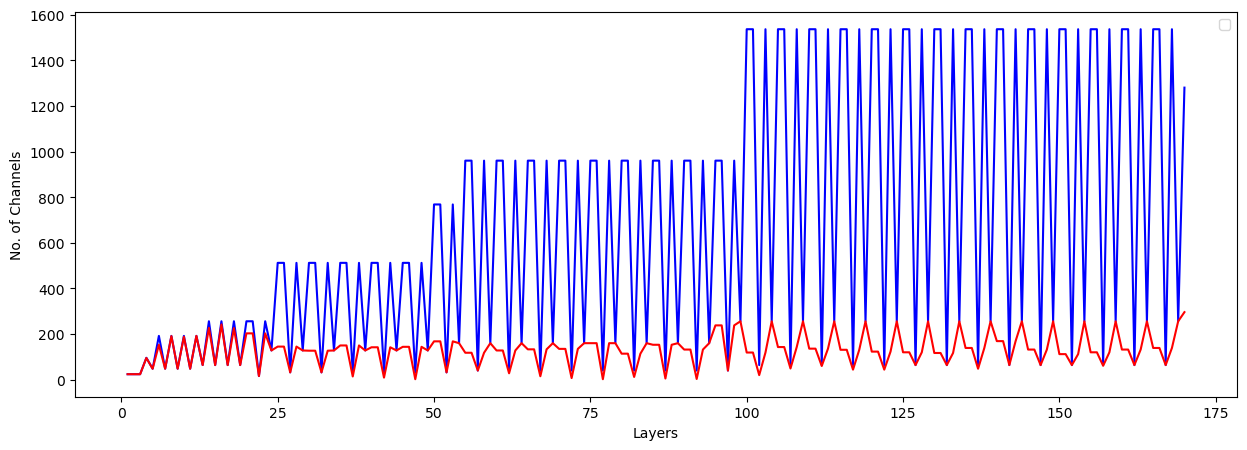

In [31]:
import matplotlib.pyplot as plt
x = range(1, 171)

# Create a figure and axis

# fig, ax = plt.subplots()
plt.figure(figsize=(15,5))

# Plot the first array with a blue curve, labeled with a marker
plt.plot(x, channels_init, color='blue')

# Plot the second array with a red curve, labeled with a marker
plt.plot(x, channels_prune, color='red')

# Add legend
plt.legend()

# Set labels for x and y axes
plt.ylabel('No. of Channels')
plt.xlabel('Layers')

# Show the plot
plt.show()

# Example usage:
import random


# Model Sizes

In [46]:
import os

file_size_bytes = os.path.getsize('/kaggle/input/pruning-effficientnet-v2-s-on-cifar10/best_model_9791.pt')
file_size_mb = file_size_bytes / (1024 * 1024)
print(f"Model file size before pruning: {file_size_mb:.2f} MB")

file_size_bytes = os.path.getsize('/kaggle/working/pruned_model_80.0%.pth')
file_size_mb = file_size_bytes / (1024 * 1024)
print(f"Model file size after pruning: {file_size_mb:.2f} MB")

Model file size before pruning: 77.99 MB
Model file size after pruning: 11.68 MB


# Few More tests 
Upto this point 80% channels are pruned, Let's try pruning 20% channels from remaining channels

In [54]:
iterative_steps = 1 # You can prune your model to the target sparsity iteratively. #importance parameter
pruner = tp.pruner.MagnitudePruner(
    model, 
    example_inputs, 
    global_pruning=True, # If False, a uniform sparsity will be assigned to different layers.
    importance=imp, # importance criterion for parameter selection
    iterative_steps=iterative_steps, # the number of iterations to achieve target sparsity
    ch_sparsity=0.2, # Remove 80% channels, 
    ignored_layers=ignored_layers,
)


In [48]:
for i in range(iterative_steps):
    pruner.step()
    print(f'Iteration   {i+1} / {iterative_steps}---------------------------')
    macs, nparams = tp.utils.count_ops_and_params(model, example_inputs)
    print(model(example_inputs).shape)
    print(
        "  Iter %d/%d, Params: %.2f M => %.2f M"
        % (i+1, iterative_steps, base_nparams / 1e6, nparams / 1e6)
    )
    print(
        "  Iter %d/%d, MACs: %.2f G => %.2f G"
        % (i+1, iterative_steps, base_macs / 1e9, macs / 1e9)
    )
    print("="*16)

Iteration   1 / 2---------------------------
torch.Size([32, 10])
  Iter 1/1, Params: 20.19 M => 2.01 M
  Iter 1/1, MACs: 2.88 G => 1.35 G


In [49]:
evaluate_model(model)

100%|██████████| 313/313 [00:21<00:00, 14.69it/s]


Evaluation Loss: 11.6117 Acc: 0.1288


(11.61174298248291, tensor(0.1288, device='cuda:0', dtype=torch.float64))

In [50]:
    criterion = nn.CrossEntropyLoss()
    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    
    model, _ = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs= 2 )
    name= 84 #this is total pruned per
#  torch.save(model, f'pruned_model_{name}%.pth')

Epoch 1/2
----------


train Loss: 0.2796 Acc: 0.9081


val Loss: 0.2133 Acc: 0.9289

Epoch 2/2
----------


train Loss: 0.1680 Acc: 0.9453


val Loss: 0.2088 Acc: 0.9326

Training complete in 8m 38s
Best val Acc: 0.932600


[24, 24, 24, 91, 48, 111, 48, 161, 48, 167, 48, 180, 64, 172, 64, 187, 64, 175, 64, 150, 150, 16, 150, 128, 101, 101, 32, 101, 128, 93, 93, 32, 93, 128, 108, 108, 14, 108, 128, 99, 99, 9, 99, 128, 115, 115, 2, 115, 128, 132, 132, 32, 132, 147, 90, 90, 40, 90, 147, 92, 92, 27, 92, 147, 87, 87, 15, 87, 147, 100, 100, 6, 100, 147, 117, 117, 1, 117, 147, 102, 102, 12, 102, 147, 121, 121, 5, 121, 147, 99, 99, 2, 99, 147, 178, 178, 40, 178, 195, 86, 86, 17, 86, 195, 106, 106, 46, 106, 195, 118, 118, 54, 118, 195, 87, 87, 42, 87, 195, 79, 79, 42, 79, 195, 99, 99, 62, 99, 195, 89, 89, 62, 89, 195, 101, 101, 47, 101, 195, 129, 129, 64, 129, 195, 87, 87, 62, 87, 195, 82, 82, 64, 82, 195, 84, 84, 60, 84, 195, 90, 90, 64, 90, 195, 107, 107, 64, 107, 195, 211]

..................
Total: 170
Pruned percentage 0.8447310216894978 %


In [52]:
torch.save(model, f'pruned_model_{name}%.pth')

Seems like we try pruning 20% more and see the results

In [55]:
for i in range(iterative_steps):
    pruner.step()
    print(f'Iteration   {i+1} / {iterative_steps}---------------------------')
    macs, nparams = tp.utils.count_ops_and_params(model, example_inputs)
    print(model(example_inputs).shape)
    print(
        "  Iter %d/%d, Params: %.2f M => %.2f M"
        % (i+1, iterative_steps, base_nparams / 1e6, nparams / 1e6)
    )
    print(
        "  Iter %d/%d, MACs: %.2f G => %.2f G"
        % (i+1, iterative_steps, base_macs / 1e9, macs / 1e9)
    )
    print("="*16)

Iteration   1 / 1---------------------------
torch.Size([32, 10])
  Iter 1/1, Params: 20.19 M => 1.36 M
  Iter 1/1, MACs: 2.88 G => 1.07 G


In [56]:
evaluate_model(model)

100%|██████████| 313/313 [00:21<00:00, 14.31it/s]

Evaluation Loss: 11.3746 Acc: 0.1000


(11.374557704162598, tensor(0.1000, device='cuda:0', dtype=torch.float64))

In [57]:
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model, _ = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                   num_epochs= 20 )
name= 87 #this is total pruned per

Epoch 1/20
----------


train Loss: 0.4493 Acc: 0.8517


val Loss: 0.2748 Acc: 0.9079

Epoch 2/20
----------


train Loss: 0.2780 Acc: 0.9084


val Loss: 0.2347 Acc: 0.9190

Epoch 3/20
----------


train Loss: 0.2258 Acc: 0.9251


val Loss: 0.2449 Acc: 0.9183

Epoch 4/20
----------


train Loss: 0.1914 Acc: 0.9369


val Loss: 0.2089 Acc: 0.9290

Epoch 5/20
----------


train Loss: 0.1618 Acc: 0.9461


val Loss: 0.2192 Acc: 0.9280

Epoch 6/20
----------


train Loss: 0.1444 Acc: 0.9527


val Loss: 0.2076 Acc: 0.9326

Epoch 7/20
----------


train Loss: 0.1243 Acc: 0.9600


val Loss: 0.2097 Acc: 0.9342

Epoch 8/20
----------


train Loss: 0.0869 Acc: 0.9728


val Loss: 0.1874 Acc: 0.9428

Epoch 9/20
----------


train Loss: 0.0750 Acc: 0.9770


val Loss: 0.1856 Acc: 0.9431

Epoch 10/20
----------


train Loss: 0.0666 Acc: 0.9792


val Loss: 0.1857 Acc: 0.9426

Epoch 11/20
----------


train Loss: 0.0635 Acc: 0.9806


val Loss: 0.1886 Acc: 0.9429

Epoch 12/20
----------


train Loss: 0.0618 Acc: 0.9810


val Loss: 0.1867 Acc: 0.9437

Epoch 13/20
----------


train Loss: 0.0573 Acc: 0.9826


val Loss: 0.1841 Acc: 0.9466

Epoch 14/20
----------


train Loss: 0.0553 Acc: 0.9826


val Loss: 0.1852 Acc: 0.9444

Epoch 15/20
----------


train Loss: 0.0525 Acc: 0.9842


val Loss: 0.1828 Acc: 0.9458

Epoch 16/20
----------


train Loss: 0.0492 Acc: 0.9854


val Loss: 0.1852 Acc: 0.9469

Epoch 17/20
----------


train Loss: 0.0509 Acc: 0.9849


val Loss: 0.1843 Acc: 0.9479

Epoch 18/20
----------


train Loss: 0.0507 Acc: 0.9842


val Loss: 0.1840 Acc: 0.9461

Epoch 19/20
----------


train Loss: 0.0499 Acc: 0.9849


val Loss: 0.1865 Acc: 0.9456

Epoch 20/20
----------


train Loss: 0.0484 Acc: 0.9853


val Loss: 0.1839 Acc: 0.9466

Training complete in 82m 17s
Best val Acc: 0.947900


In [59]:
torch.save(model, f'pruned_model_{name}%.pth')

# Final Pruned model visualization

In [17]:
import numpy as np
channels_init = [24, 24, 24, 96, 48, 192, 48, 192, 48, 192, 48, 192, 64, 256, 64, 256, 64, 256, 64, 256, 256, 16, 256, 128, 512, 512, 32, 512, 128, 512, 512, 32, 512, 128, 512, 512, 32, 512, 128, 512, 512, 32, 512, 128, 512, 512, 32, 512, 128, 768, 768, 32, 768, 160, 960, 960, 40, 960, 160, 960, 960, 40, 960, 160, 960, 960, 40, 960, 160, 960, 960, 40, 960, 160, 960, 960, 40, 960, 160, 960, 960, 40, 960, 160, 960, 960, 40, 960, 160, 960, 960, 40, 960, 160, 960, 960, 40, 960, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1536, 1536, 64, 1536, 256, 1280]
channels_prune = get_channel_sizes(model)

channels_init = np.array(channels_init)
channels_prune = np.array(channels_prune)
total_ch_initialy = np.sum(channels_init)
total_ch_prune = np.sum(channels_prune)

per =  (total_ch_initialy-total_ch_prune)/total_ch_initialy

print(f'Pruned percentage {per} %')


[24, 24, 24, 77, 48, 84, 48, 127, 48, 134, 48, 145, 64, 132, 64, 139, 64, 134, 64, 109, 109, 16, 109, 128, 82, 82, 32, 82, 128, 78, 78, 32, 78, 128, 88, 88, 14, 88, 128, 78, 78, 9, 78, 128, 88, 88, 2, 88, 128, 98, 98, 32, 98, 113, 64, 64, 40, 64, 113, 66, 66, 26, 66, 113, 60, 60, 15, 60, 113, 68, 68, 6, 68, 113, 88, 88, 1, 88, 113, 78, 78, 12, 78, 113, 94, 94, 5, 94, 113, 65, 65, 2, 65, 113, 128, 128, 40, 128, 148, 71, 71, 14, 71, 148, 77, 77, 42, 77, 148, 100, 100, 44, 100, 148, 70, 70, 40, 70, 148, 61, 61, 35, 61, 148, 75, 75, 54, 75, 148, 57, 57, 58, 57, 148, 70, 70, 45, 70, 148, 91, 91, 64, 91, 148, 76, 76, 58, 76, 148, 59, 59, 61, 59, 148, 61, 61, 56, 61, 148, 64, 64, 63, 64, 148, 84, 84, 63, 84, 148, 159]

..................
Total: 170
Pruned percentage 0.8779876569634704 %


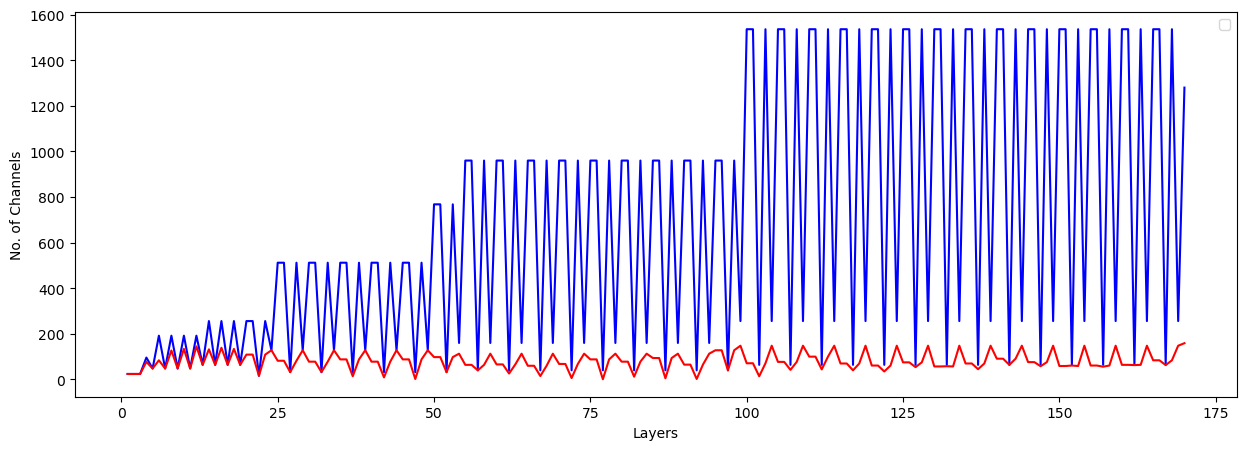

In [18]:
import matplotlib.pyplot as plt
x = range(1, 171)

# Create a figure and axis

# fig, ax = plt.subplots()
plt.figure(figsize=(15,5))

# Plot the first array with a blue curve, labeled with a marker
plt.plot(x, channels_init, color='blue')

# Plot the second array with a red curve, labeled with a marker
plt.plot(x, channels_prune, color='red')

# Add legend
plt.legend()

# Set labels for x and y axes
plt.ylabel('No. of Channels')
plt.xlabel('Layers')

# Show the plot
plt.show()

# Example usage:
import random


Iteration   1 / 1---------------------------
torch.Size([32, 10])
  Iter 1/1, Params: 20.19 M => 1.36 M
  Iter 1/1, MACs: 2.88 G => 1.07 G


# Measuring Inference time and model size


In [1]:
! pip install nn-meter
!nn-meter --list-predictors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 3.0 MB/s eta 0:00:00a 0:00:01
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/pkg_resources/__init__.py", line 3031, in _dep_map
    return self.__dep_map
  File "/opt/conda/lib/python3.10/site-packages/pkg_resources/__init__.py", line 2828, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/pkg_resources/__init__.py", line 3022, in _parsed_pkg_info
    return self._pkg_info
  File "/opt/conda/lib/python3.10/site-packages/pkg_resources/__init__.py", line 2828, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info. Did you mean: 'egg_info'?

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/bin/nn-meter", line 5,

In [9]:
!pip install onnx
!pip install onnx-simplifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.3 MB/s eta 0:00:00a 0:00:01


In [5]:
# from nn_meter import load_latency_predictor
m_org = torch.load('/kaggle/input/pruning-effficientnet-v2-s-on-cifar10/best_model_9791.pt', map_location = torch.device('cpu')) #81% pruned model, unstructured
m_pruned = torch.load('/kaggle/working/pruned_model_87%.pth',  map_location = torch.device('cpu')) #original model

In [6]:
from nn_meter import load_latency_predictor

In [13]:
predictor = load_latency_predictor('cortexA76cpu_tflite21', 1.0)
lat_org = predictor.predict(m_org, 'torch')
lat_pruned = predictor.predict(m_pruned, 'torch')

(nn-Meter) checking local kernel predictors at /root/.nn_meter/data/predictor/cortexA76cpu_tflite21
(nn-Meter) load predictor /root/.nn_meter/data/predictor/cortexA76cpu_tflite21/avgpool.pkl
(nn-Meter) load predictor /root/.nn_meter/data/predictor/cortexA76cpu_tflite21/bn.pkl
(nn-Meter) load predictor /root/.nn_meter/data/predictor/cortexA76cpu_tflite21/concat.pkl


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


(nn-Meter) load predictor /root/.nn_meter/data/predictor/cortexA76cpu_tflite21/se.pkl
(nn-Meter) load predictor /root/.nn_meter/data/predictor/cortexA76cpu_tflite21/dwconv-bn-relu.pkl
(nn-Meter) load predictor /root/.nn_meter/data/predictor/cortexA76cpu_tflite21/relu.pkl
(nn-Meter) load predictor /root/.nn_meter/data/predictor/cortexA76cpu_tflite21/bnrelu.pkl
(nn-Meter) load predictor /root/.nn_meter/data/predictor/cortexA76cpu_tflite21/fc.pkl
(nn-Meter) load predictor /root/.nn_meter/data/predictor/cortexA76cpu_tflite21/hswish.pkl
(nn-Meter) load predictor /root/.nn_meter/data/predictor/cortexA76cpu_tflite21/add.pkl
(nn-Meter) load predictor /root/.nn_meter/data/predictor/cortexA76cpu_tflite21/maxpool.pkl
(nn-Meter) load predictor /root/.nn_meter/data/predictor/cortexA76cpu_tflite21/channelshuffle.pkl
(nn-Meter) load predictor /root/.nn_meter/data/predictor/cortexA76cpu_tflite21/conv-bn-relu.pkl
(nn-Meter) load predictor /root/.nn_meter/data/predictor/cortexA76cpu_tflite21/addrelu.pkl

In [14]:
print(f'Latency of original model: {lat_org}')
print(f'Latency of pruned model: {lat_pruned}')

Latency of original model: 328.95630089686364
Latency of pruned model: 128.62758512246805


In [35]:
import os
file_size_bytes = os.path.getsize('/kaggle/input/pruning-effficientnet-v2-s-on-cifar10/best_model_9791.pt')
file_size_mb = file_size_bytes / (1024 * 1024)
print(f"Model file size before pruning: {file_size_mb:.2f} MB")

file_size_bytes = os.path.getsize('/kaggle/working/pruned_model_87%.pth')
file_size_mb = file_size_bytes / (1024 * 1024)
print(f"Model file size after pruning: {file_size_mb:.2f} MB")

Model file size before pruning: 77.99 MB
Model file size after pruning: 5.66 MB


# Ideas to generate insigths

In [ ]:
#progressive retraining, channels are being pruned not parameters

#ideas for plotting and generating insights, init size =80mb, accu=97.92
#size and pruning 
#accuracy with prunning
#mac redn vs pruned per vs prar dis
#retrain epochs effect, recovery process
#channel comparsion:intial and after pruned
#Inference time comparison

# Replacing Silu with hswish and sigmoid with hsigmoid
I need to deploy the model in FPG siLU is expensive

In [23]:
i=0
def replace_layer(m):
    global i 
    for name, child in m.named_children():
        if len(list(child.children()))> 0:
            replace_layer(child)
        
        elif isinstance(child, nn.SiLU):
            setattr(m, name, nn.Hardswish(inplace=True))
            i=i+1

replace_layer(model)
print(f'{i} SiLU layers replaced with hard-swish layers')

102 SiLU layers replaced with hard-swish layers


In [24]:
#checking if there is anu SiLU left
for module in model.modules():
    if isinstance(module, nn.SiLU):
        what=True
    else: 
        what = False

print('SiLU Layers: ', what)

SiLU Layers:  False


In [26]:
evaluate_model(model)

100%|██████████| 313/313 [00:30<00:00, 10.30it/s]

Evaluation Loss: 0.5765 Acc: 0.8418


(0.576501197385788, tensor(0.8418, device='cuda:0', dtype=torch.float64))

some reduction in accuracy, Let's recover it by retraining it for few epochs

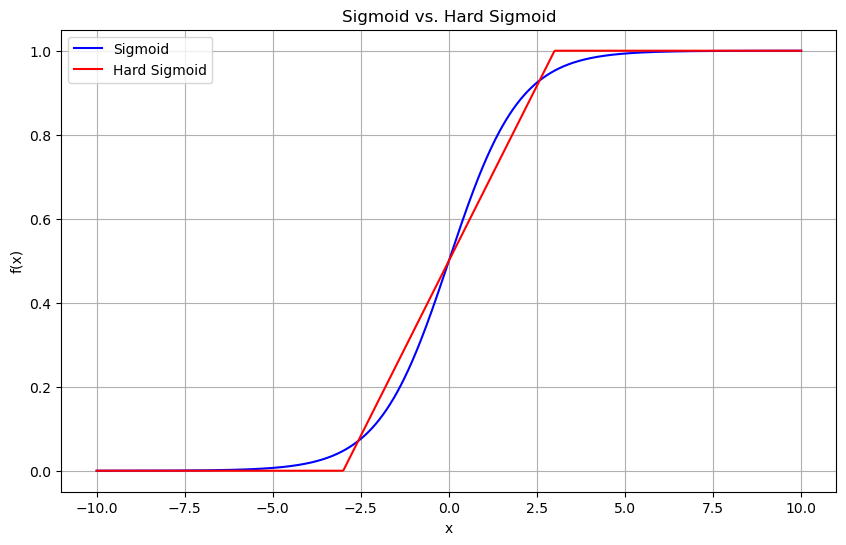

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Define the hard sigmoid function
def hard_sigmoid(x):
    return np.clip(x/6 + 0.5, 0, 1)

# Generate data for the plot
x = np.linspace(-10, 10, 1000)
y_sigmoid = sigmoid(x)
y_hard_sigmoid = hard_sigmoid(x)

# Plot the sigmoid and hard sigmoid functions
plt.figure(figsize=(10, 6))
plt.plot(x, y_sigmoid, label='Sigmoid', color='blue')
plt.plot(x, y_hard_sigmoid, label='Hard Sigmoid', color='red')

# Set plot labels and title
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Sigmoid vs. Hard Sigmoid')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [32]:
#need to replace sigmoid too

i=0
def replace_layer(m):
    global i 
    for name, child in m.named_children():
        if len(list(child.children()))> 0:
            replace_layer(child)
        
        elif isinstance(child, nn.Sigmoid):
            setattr(m, name, nn.Hardsigmoid())
            i=i+1

replace_layer(model)
print(f'{i} Sigmoid layers replaced with hard-sigmoid layers')


30 Sigmoid layers replaced with hard-sigmoid layers


In [33]:
evaluate_model(model)

100%|██████████| 313/313 [00:24<00:00, 12.63it/s]

Evaluation Loss: 0.6638 Acc: 0.8217


(0.6638343986749649, tensor(0.8217, device='cuda:0', dtype=torch.float64))

## Recovering the loss

In [36]:
# Further train for 20 more epochs

criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model, epoch_data = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                   num_epochs= 20 )
 #this is total pruned per
torch.save(model, f'EfficientnetV2_S_hswish87.pth')

Epoch 1/20
----------


train Loss: 0.1443 Acc: 0.9519


val Loss: 0.2258 Acc: 0.9286

Epoch 2/20
----------


train Loss: 0.1199 Acc: 0.9597


val Loss: 0.2040 Acc: 0.9367

Epoch 3/20
----------


train Loss: 0.1052 Acc: 0.9655


val Loss: 0.2075 Acc: 0.9357

Epoch 4/20
----------


train Loss: 0.0930 Acc: 0.9692


val Loss: 0.2160 Acc: 0.9341

Epoch 5/20
----------


train Loss: 0.0864 Acc: 0.9712


val Loss: 0.2067 Acc: 0.9367

Epoch 6/20
----------


train Loss: 0.0811 Acc: 0.9729


val Loss: 0.2145 Acc: 0.9338

Epoch 7/20
----------


train Loss: 0.0715 Acc: 0.9763


val Loss: 0.2023 Acc: 0.9383

Epoch 8/20
----------


train Loss: 0.0494 Acc: 0.9849


val Loss: 0.1847 Acc: 0.9456

Epoch 9/20
----------


train Loss: 0.0393 Acc: 0.9880


val Loss: 0.1831 Acc: 0.9462

Epoch 10/20
----------


train Loss: 0.0348 Acc: 0.9894


val Loss: 0.1834 Acc: 0.9456

Epoch 11/20
----------


train Loss: 0.0320 Acc: 0.9913


val Loss: 0.1825 Acc: 0.9478

Epoch 12/20
----------


train Loss: 0.0310 Acc: 0.9912


val Loss: 0.1839 Acc: 0.9472

Epoch 13/20
----------


train Loss: 0.0293 Acc: 0.9916


val Loss: 0.1836 Acc: 0.9480

Epoch 14/20
----------


train Loss: 0.0279 Acc: 0.9919


val Loss: 0.1861 Acc: 0.9478

Epoch 15/20
----------


train Loss: 0.0261 Acc: 0.9926


val Loss: 0.1844 Acc: 0.9488

Epoch 16/20
----------


train Loss: 0.0241 Acc: 0.9934


val Loss: 0.1866 Acc: 0.9480

Epoch 17/20
----------


train Loss: 0.0241 Acc: 0.9935


val Loss: 0.1835 Acc: 0.9481

Epoch 18/20
----------


train Loss: 0.0252 Acc: 0.9930


val Loss: 0.1848 Acc: 0.9480

Epoch 19/20
----------


train Loss: 0.0261 Acc: 0.9925


val Loss: 0.1849 Acc: 0.9483

Epoch 20/20
----------


train Loss: 0.0246 Acc: 0.9933


val Loss: 0.1869 Acc: 0.9478

Training complete in 91m 45s
Best val Acc: 0.948800
